In [1]:
import os
import numpy as np
import pandas as pd
idx = pd.IndexSlice

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
colors = sns.color_palette()

In [2]:
from scipy import stats

from utils import abcd, plotting
ABCD_PATH = '../../ABCD'

In [3]:
fcon, fc_extra = abcd.load_mri_data(ABCD_PATH, 'fcon', dropna=True)

subs = fcon.index.get_level_values(0).unique()
print(len(subs), 'subjects')

4188 subjects


In [4]:
covariates = abcd.load_covariates('output/abcd_covariates.csv', simple_race=True)

# Scanner

In [5]:
scan = fc_extra[abcd.SCAN_INFO].join(covariates['site_id']).fillna(method='bfill')

## One-way ANOVA

In [6]:
manufacts = scan.groupby('mri_info_manufacturer').groups
fcon_manufacts_F = stats.f_oneway(*[fcon.loc[ids] for ids in manufacts.values()])

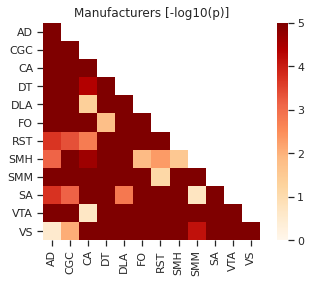

In [7]:
with sns.axes_style('ticks'):
    ax = plotting.plot_fcon(-np.log10(fcon_manufacts_F.pvalue),
                            cmap='OrRd', vmin=0, vmax=5)

ax.set_title('Manufacturers [-log10(p)]')
plt.show()

In [8]:
models = scan.loc[manufacts['SIEMENS']].groupby('mri_info_manufacturersmn').groups
fcon_models_F = stats.f_oneway(*[fcon.loc[ids] for ids in models.values()])

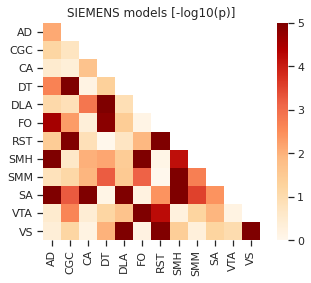

In [9]:
with sns.axes_style('ticks'):
    ax = plotting.plot_fcon(-np.log10(fcon_models_F.pvalue),
                            cmap='OrRd', vmin=0, vmax=5)

ax.set_title('SIEMENS models [-log10(p)]')
plt.show()

In [10]:
devices = scan.loc[models['Prisma_fit']].groupby('mri_info_deviceserialnumber').groups
fcon_devices_F = stats.f_oneway(*[fcon.loc[ids] for ids in devices.values()])

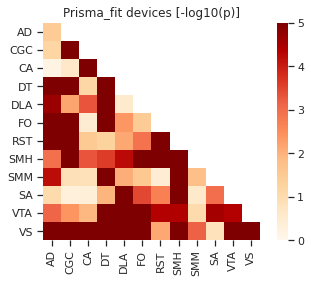

In [11]:
with sns.axes_style('ticks'):
    ax = plotting.plot_fcon(-np.log10(fcon_devices_F.pvalue),
                            cmap='OrRd', vmin=0, vmax=5)

ax.set_title('Prisma_fit devices [-log10(p)]')
plt.show()

## Univariate Regressions

In [12]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools import tools as sm_tools

In [13]:
def confound_r2s(df, confounds, adjusted=False, n_workers=None):
    sample = df.index.intersection(confounds.index)
    confounds = pd.DataFrame(confounds.loc[sample]) # prevent get_dummies on numeric
    
    exog = sm_tools.add_constant(pd.get_dummies(confounds, drop_first=True))
    if adjusted:
        calc_r2s = lambda col: sm.OLS(col, exog).fit().rsquared_adj
    else:
        calc_r2s = lambda col: sm.OLS(col, exog).fit().rsquared
    
    if n_workers is not None:
        import mapply
        mapply.init(n_workers=n_workers, chunk_size=1, progressbar=True)
        r2s = df.loc[sample].mapply(calc_r2s)
    else:
        r2s = df.loc[sample].apply(calc_r2s)
    
    return r2s

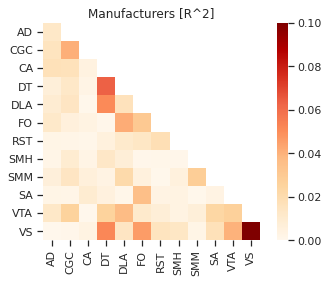

In [14]:
with sns.axes_style('ticks'):
    ax = plotting.plot_fcon(
        confound_r2s(fcon, scan['mri_info_manufacturer']),
        cmap='OrRd', vmax=0.10, vmin=0
    )

ax.set_title('Manufacturers [R^2]')
plt.show()

### SIEMENS

In [15]:
scan.loc[manufacts['SIEMENS'], 'mri_info_manufacturersmn'].value_counts()

Prisma_fit    2688
Prisma        2603
Name: mri_info_manufacturersmn, dtype: int64

In [16]:
scan.loc[manufacts['SIEMENS'], 'mri_info_softwareversion'].value_counts()

syngo MR E11    5291
Name: mri_info_softwareversion, dtype: int64

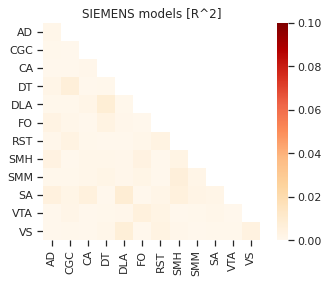

In [17]:
with sns.axes_style('ticks'):
    ax = plotting.plot_fcon(
        confound_r2s(fcon, scan.loc[manufacts['SIEMENS'], 'mri_info_manufacturersmn']),
        cmap='OrRd', vmax=0.10, vmin=0
    )

ax.set_title('SIEMENS models [R^2]')
plt.show()

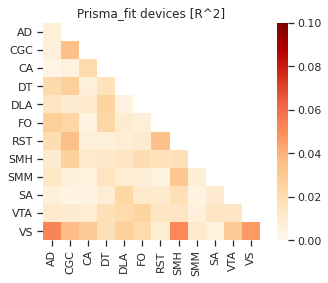

In [18]:
with sns.axes_style('ticks'):
    ax = plotting.plot_fcon(
        confound_r2s(fcon, scan.loc[models['Prisma_fit'], 'mri_info_deviceserialnumber']),
        cmap='OrRd', vmax=0.10, vmin=0
    )

ax.set_title('Prisma_fit devices [R^2]')
plt.show()

### GE

In [19]:
scan.loc[manufacts['GE MEDICAL SYSTEMS'], 'mri_info_manufacturersmn'].value_counts()

DISCOVERY MR750    2087
Name: mri_info_manufacturersmn, dtype: int64

In [20]:
scan.loc[manufacts['GE MEDICAL SYSTEMS'], 'mri_info_softwareversion'].value_counts()

25\LX\MR Software release:DV25.0_R02_1549.b    944
27\LX\MR Software release:DV26.0_R02_1810.b    539
27\LX\MR Software release:DV26.0_R01_1725.a    468
27\LX\MR Software release:DV26.0_R03_1831.b    109
27\LX\MR Software release:DV25.1_R01_1617.b     25
27\LX\MR Software release:DV26.0_EB_1707.b       2
Name: mri_info_softwareversion, dtype: int64

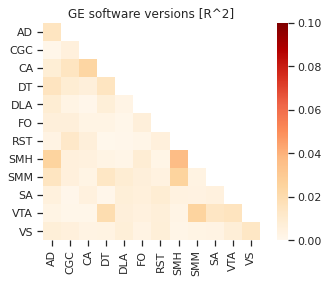

In [21]:
with sns.axes_style('ticks'):
    ax = plotting.plot_fcon(
        confound_r2s(fcon, scan.loc[manufacts['GE MEDICAL SYSTEMS'], 'mri_info_softwareversion']),
        cmap='OrRd', vmax=0.10, vmin=0
    )

ax.set_title('GE software versions [R^2]')
plt.show()

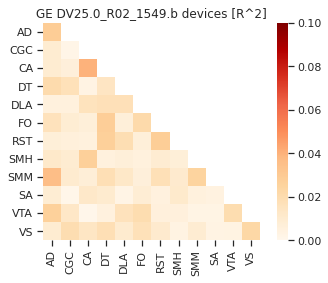

In [22]:
with sns.axes_style('ticks'):
    ax = plotting.plot_fcon(
        confound_r2s(fcon, scan.loc[
            scan['mri_info_softwareversion'].str.endswith('DV25.0_R02_1549.b'),
            'mri_info_deviceserialnumber']),
        cmap='OrRd', vmax=0.10, vmin=0
    )

ax.set_title('GE DV25.0_R02_1549.b devices [R^2]')
plt.show()

### Philips

In [23]:
scan.loc[manufacts['Philips Medical Systems'], 'mri_info_manufacturersmn'].value_counts()

Achieva dStream    630
Ingenia            368
Name: mri_info_manufacturersmn, dtype: int64

In [24]:
scan.loc[manufacts['Philips Medical Systems'], 'mri_info_softwareversion'].value_counts()

5.3.0\5.3.0.0    295
5.3.1\5.3.1.0    153
5.4.0\5.4.0.1    127
5.3.0\5.3.0.3    121
5.4.1\5.4.1.1    114
5.3.1\5.3.1.2     99
5.3.1\5.3.1.1     61
5.3.1\5.3.1.3     28
Name: mri_info_softwareversion, dtype: int64

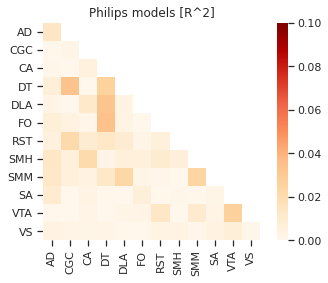

In [25]:
with sns.axes_style('ticks'):
    ax = plotting.plot_fcon(
        confound_r2s(fcon, scan.loc[manufacts['Philips Medical Systems'],
                                    'mri_info_manufacturersmn']),
        cmap='OrRd', vmax=0.10, vmin=0
    )

ax.set_title('Philips models [R^2]')
plt.show()

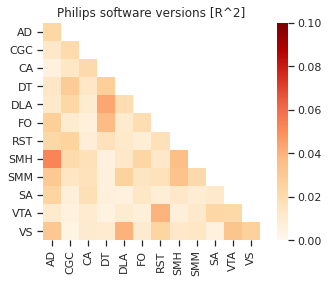

In [26]:
with sns.axes_style('ticks'):
    ax = plotting.plot_fcon(
        confound_r2s(fcon, scan.loc[manufacts['Philips Medical Systems'],
                                    'mri_info_softwareversion']),
        cmap='OrRd', vmax=0.10, vmin=0
    )

ax.set_title('Philips software versions [R^2]')
plt.show()

### Single-site

In [27]:
scan.loc[scan['site_id'] == 'site04'].value_counts()

mri_info_manufacturer  mri_info_manufacturersmn  mri_info_deviceserialnumber  mri_info_softwareversion                     site_id
GE MEDICAL SYSTEMS     DISCOVERY MR750           HASH4b0b8b05                 25\LX\MR Software release:DV25.0_R02_1549.b  site04     223
                                                                              27\LX\MR Software release:DV26.0_R02_1810.b  site04     212
                                                 HASHfeb7e81a                 25\LX\MR Software release:DV25.0_R02_1549.b  site04     126
                                                                              27\LX\MR Software release:DV26.0_R02_1810.b  site04     101
dtype: int64

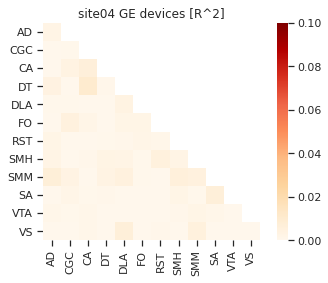

In [28]:
with sns.axes_style('ticks'):
    ax = plotting.plot_fcon(
        confound_r2s(fcon, scan.loc[scan['site_id'] == 'site04', 'mri_info_deviceserialnumber']),
        cmap='OrRd', vmax=0.10, vmin=0
    )

ax.set_title('site04 GE devices [R^2]')
plt.show()

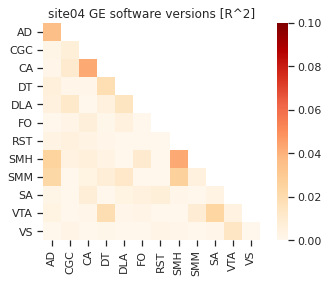

In [29]:
with sns.axes_style('ticks'):
    ax = plotting.plot_fcon(
        confound_r2s(fcon, scan.loc[scan['site_id'] == 'site04', 'mri_info_softwareversion']),
        cmap='OrRd', vmax=0.10, vmin=0
    )

ax.set_title('site04 GE software versions [R^2]')
plt.show()

## Adjusted R2 (LONG)

In [30]:
def powerset(iterable):
    from itertools import chain, combinations
    s = list(iterable)
    
    return chain.from_iterable(combinations(s, r) for r in range(1, 1 + len(s)))

In [31]:
from joblib import Parallel, delayed

def adjusted_r2s(confound_set):
    s = confound_r2s(fcon, scan[list(confound_set)], adjusted=True).describe()
    return s.rename(str(confound_set))

results = Parallel(n_jobs=4)(delayed(adjusted_r2s)(c) for c in powerset(scan.columns))
results_df = pd.concat(results, axis=1).T

In [32]:
results_df.sort_values('mean', ascending=False).head()

,count,mean,std,min,25%,50%,75%,max
"('mri_info_manufacturer', 'mri_info_deviceserialnumber', 'mri_info_softwareversion')",78.0,0.028104,0.021053,0.001924,0.015954,0.021932,0.038236,0.133685
"('mri_info_deviceserialnumber', 'mri_info_softwareversion')",78.0,0.027991,0.020965,0.001784,0.016026,0.022204,0.037695,0.134103
"('mri_info_manufacturersmn', 'mri_info_deviceserialnumber', 'mri_info_softwareversion', 'site_id')",78.0,0.027897,0.020951,0.000862,0.016110,0.020979,0.037674,0.133486
"('mri_info_manufacturersmn', 'mri_info_deviceserialnumber', 'mri_info_softwareversion')",78.0,0.027871,0.021118,0.001797,0.015909,0.021397,0.037771,0.134395
"('mri_info_softwareversion', 'site_id')",78.0,0.027851,0.021116,0.001630,0.015664,0.021571,0.037847,0.134506


In [34]:
results_df.sort_values('50%', ascending=False).head()

,count,mean,std,min,25%,50%,75%,max
"('mri_info_deviceserialnumber', 'mri_info_softwareversion')",78.0,0.027991,0.020965,0.001784,0.016026,0.022204,0.037695,0.134103
"('mri_info_manufacturer', 'mri_info_deviceserialnumber', 'mri_info_softwareversion')",78.0,0.028104,0.021053,0.001924,0.015954,0.021932,0.038236,0.133685
"('mri_info_softwareversion', 'site_id')",78.0,0.027851,0.021116,0.001630,0.015664,0.021571,0.037847,0.134506
"('mri_info_manufacturer', 'mri_info_manufacturersmn', 'mri_info_deviceserialnumber', 'mri_info_softwareversion')",78.0,0.027810,0.020967,0.001783,0.015881,0.021491,0.038071,0.133259
"('mri_info_manufacturersmn', 'mri_info_deviceserialnumber', 'mri_info_softwareversion')",78.0,0.027871,0.021118,0.001797,0.015909,0.021397,0.037771,0.134395


In [35]:
results_df.sort_values('max', ascending=False).head()

,count,mean,std,min,25%,50%,75%,max
"('mri_info_softwareversion', 'site_id')",78.0,0.027851,0.021116,0.001630,0.015664,0.021571,0.037847,0.134506
"('mri_info_deviceserialnumber',)",78.0,0.027037,0.020950,0.001032,0.014967,0.020417,0.034327,0.134483
"('mri_info_manufacturersmn', 'mri_info_deviceserialnumber', 'mri_info_softwareversion')",78.0,0.027871,0.021118,0.001797,0.015909,0.021397,0.037771,0.134395
"('mri_info_manufacturer', 'mri_info_manufacturersmn', 'mri_info_softwareversion', 'site_id')",78.0,0.027578,0.020967,0.001662,0.015642,0.020674,0.037487,0.134173
"('mri_info_deviceserialnumber', 'mri_info_softwareversion')",78.0,0.027991,0.020965,0.001784,0.016026,0.022204,0.037695,0.134103


# Demographic

In [36]:
demo = covariates.loc[fcon.index, [
    'sex', 'race', 'hisp', 'married', 'comb_income.3level', 'highest_ed.5level'
]]

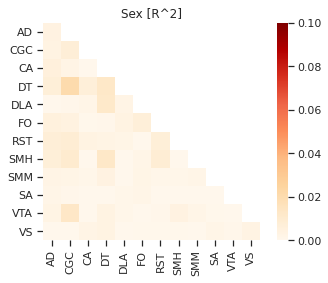

In [37]:
with sns.axes_style('ticks'):
    ax = plotting.plot_fcon(
        confound_r2s(fcon, demo['sex']),
        cmap='OrRd', vmax=0.10, vmin=0
    )

ax.set_title('Sex [R^2]')
plt.show()

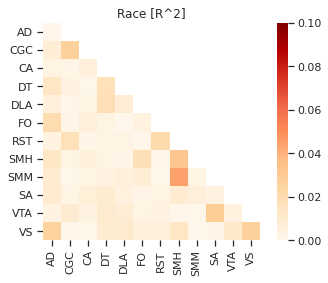

In [38]:
with sns.axes_style('ticks'):
    ax = plotting.plot_fcon(
        confound_r2s(fcon, demo[['race', 'hisp']].dropna()),
        cmap='OrRd', vmax=0.10, vmin=0
    )

ax.set_title('Race [R^2]')
plt.show()

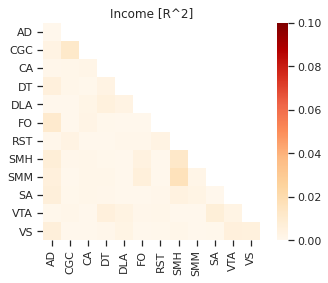

In [39]:
freq_code = demo['comb_income.3level'].value_counts() / len(demo)

with sns.axes_style('ticks'):
    ax = plotting.plot_fcon(
        confound_r2s(fcon, demo['comb_income.3level'].map(freq_code).dropna()),
        cmap='OrRd', vmax=0.10, vmin=0
    )

ax.set_title('Income [R^2]')
plt.show()

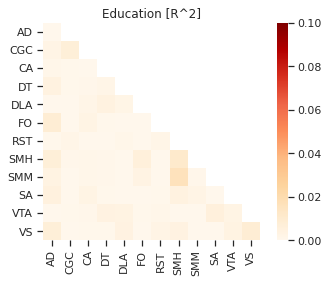

In [40]:
freq_code = demo['highest_ed.5level'].value_counts() / len(demo)

with sns.axes_style('ticks'):
    ax = plotting.plot_fcon(
        confound_r2s(fcon, demo['highest_ed.5level'].map(freq_code).dropna()),
        cmap='OrRd', vmax=0.10, vmin=0
    )

ax.set_title('Education [R^2]')
plt.show()

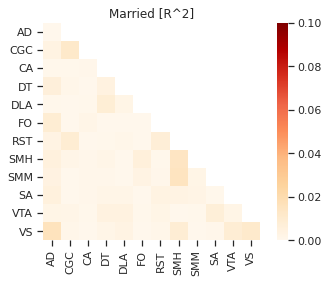

In [41]:
with sns.axes_style('ticks'):
    ax = plotting.plot_fcon(
        confound_r2s(fcon, demo['married'].dropna()),
        cmap='OrRd', vmax=0.10, vmin=0
    )

ax.set_title('Married [R^2]')
plt.show()

# Age x Motion

Replication
* subject similarity
* multidimensional scaling

TODO
* bootstrap + violin plot
* age ~ motion ~ FC
    * Bayesian network?
* SC

Thoughts
* How to score a confound (effect vs model size)
* How to aggregate scores across multiple features
* How to choose significant confounds